In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import jit
import time

%matplotlib inline

In [2]:
@jit(nopython=True)
def generate_v_OU(nr_trials=1000, noise_sd=1, tmax=5, dt=0.01, start=2, end=5):
    
    assert start <= tmax, 'start more than tmax'
    assert end <= tmax, 'end more than than tmax'
    assert start < end, 'are you high?'
    
    
    start = int(start/dt)
    end = int(end/dt)
    sim_time = int(tmax/dt)
    
    
    v = np.zeros(shape=(2, nr_trials, sim_time))
    v[0, :, start:end] = 1*dt
    
    
    v += np.random.normal(loc=0, scale=noise_sd/np.sqrt(2), size=v.shape)*np.sqrt(dt)
    return v
    
    
@jit(nopython=True)   
def get_OU_traces(v, ll, dc, z, noise_sd=1, pre_generated=False, nr_trials=1000, tmax=5.0, dt=0.01):
    
    
    x1 = np.zeros((nr_trials, int(tmax/dt)))
    x2 = np.zeros((nr_trials, int(tmax/dt)))
    x1[:,:] = np.NaN
    x2[:,:] = np.NaN
    x1[:,0] = z[0]
    x2[:,0] = z[1]
    for i in range((int(tmax/dt))-1):
        if pre_generated:
            x1[:,i+1] = x1[:,i] + v[0][:,i] + (dc[0] - (ll[0]*x1[:,i]))*dt
            x2[:,i+1] = x2[:,i] + v[1][:,i] + (dc[1] - (ll[1]*x2[:,i]))*dt
        else:
            x1[:,i+1] = x1[:,i] + ((v[0] + dc[0] - (ll[0]*x1[:,i])) * dt) +(np.random.normal(0,noise_sd/np.sqrt(2),nr_trials)*np.sqrt(dt))
            x2[:,i+1] = x2[:,i] + ((v[1] + dc[1] - (ll[1]*x2[:,i])) * dt) + (np.random.normal(0,noise_sd/np.sqrt(2),nr_trials)*np.sqrt(dt))
    return x1-x2

@jit(nopython=True)
def apply_bounds_diff_trace(x, b1, b0):
    rt = np.zeros(x.shape[0])
    rt[:] = np.nan
    response = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i,j] >= b1[j]:
                rt[i] = j
                response[i] = 1
                break
    return rt, response



def sim(v, ll1, ll2,trials, start, end, tmax, dt):
    
    ll = np.array([ll1, ll2])
    dc = np.array([0.0, 0.0])
    z = np.array([0.0, 0.0])

    
    x = get_OU_traces(v=v, ll=ll, dc=dc, z=z, pre_generated=True, nr_trials=trials, tmax = tmax, dt=dt)
    b1 = np.ones(x.shape[1])
    b0 = np.ones(x.shape[1]) * -1
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df = pd.DataFrame()
    df['rt'] = rt * dt
    df['response'] = response
    
    df['false alarm'] = (df['response'] == 1) & (df['rt'] < start)
    df['hit'] = (df['response'] == 1) & (df['rt'] >= start) & (df['rt'] <= end)
    df['miss'] = (~df['hit']) & (~df['false alarm'])
    #df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
    
    return (x, df, df['false alarm'].mean(), df['hit'].mean(), df['miss'].mean(), df['rt'].mean())

In [18]:
start = time.time()


n = 100
start_stim = 8
end_stim = start_stim + 3
ll = np.linspace(0, 8, n)
trials = 100
tmax = 13
dt = 0.01
hr = []
far = []
v = generate_v_OU(nr_trials = trials, tmax=tmax, dt=dt, start=start_stim, end=end_stim)
miss = []

for i in range(len(ll)):
#     v = generate_v_OU(nr_trials = trials, tmax=tmax, dt=dt, start=start_stim, end=end_stim)
    
    _, _, f, h, m, r = sim(v, ll[i], ll[i], trials, start=start_stim, end=end_stim, tmax=tmax, dt=dt)
    
    hr.append(h / (h+m))
    far.append(f)
    miss.append(m)

print(time.time() - start)

1.7268600463867188


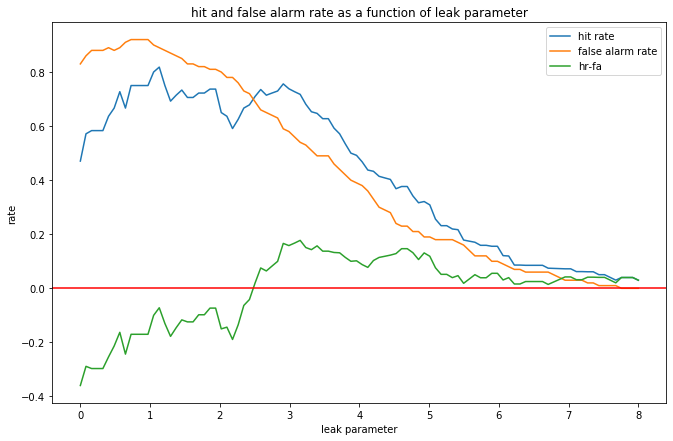

In [21]:
plt.subplots(figsize = (11, 7))
plt.plot(ll, hr, label = 'hit rate')
plt.plot(ll, far, label = 'false alarm rate')
plt.plot(ll, np.array(hr)-np.array(far), label = 'hr-fa')
plt.ylabel('rate')
plt.xlabel('leak parameter')
plt.title('hit and false alarm rate as a function of leak parameter')
plt.axhline(0, color='red')
plt.legend()

In [11]:
start_time = time.time()


n = 20
start_stim = 8
end_stim = start_stim + 3
ll = np.linspace(1, 5, n)
trials = 1000
tmax = 13
dt = 0.01
optimal_leak = []
end_stim = start_stim + np.arange(1, 5, 0.5)


for t in end_stim:
    v = generate_v_OU(nr_trials = trials, tmax=tmax, dt=dt, start=start_stim, end=t)
    hit = np.zeros(n)
    
    for i in range(len(ll)):
        _, _, f, h, m, r = sim(v, ll[i], ll[i], trials, start=start_stim, end=t, tmax=tmax, dt=dt)
        hit[i] = h / (h + m)
    
    
    index = np.argmax(hit)
    
    optimal_leak.append(ll[index])


print(time.time() - start_time)

22.663461685180664


Text(0.5, 1.0, 'optimal leak as a function of time of stimulus')

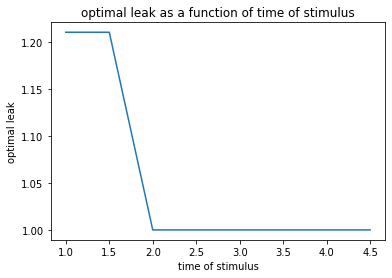

In [12]:
plt.plot(end_stim-8, optimal_leak)
plt.ylabel('optimal leak')
plt.xlabel('time of stimulus')
plt.title('optimal leak as a function of time of stimulus')

In [46]:
start_time = time.time()


n = 20
start_stim = 8
end_stim = start_stim + 3
ll = np.linspace(1, 5, n)
trials = 1000
tmax = 13
dt = 0.01
hr = []
far = []
end_stim = start_stim + np.arange(1, 5, 0.5)


for t in end_stim:
    v = generate_v_OU(nr_trials = trials, tmax=tmax, dt=dt, start=start_stim, end=t)
    hit = np.zeros(n)
   
    _, _, f, h, m, r = sim(v, 4, 4, trials, start=start_stim, end=t, tmax=tmax, dt=dt)
    
    hr.append(h)
    far.append(f)

print(time.time() - start_time)

2.93754506111145


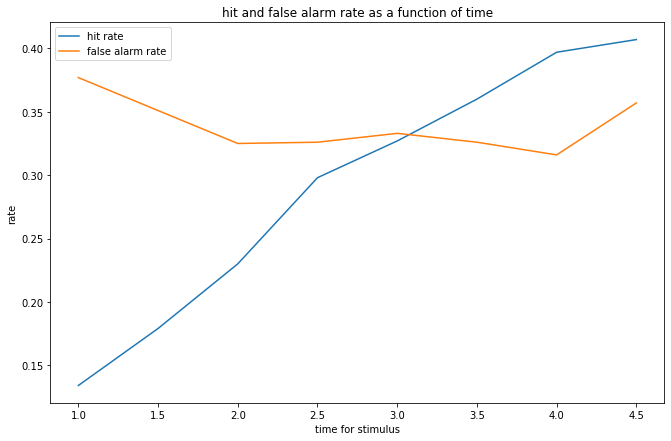

In [47]:
plt.subplots(figsize = (11, 7))
plt.plot(end_stim-8, hr, label = 'hit rate')
plt.plot(end_stim-8, far, label = 'false alarm rate')
plt.ylabel('rate')
plt.xlabel('time for stimulus')
plt.title('hit and false alarm rate as a function of time')
plt.legend()